In [1]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except: #Throws if already set
    pass

# Disable CUDA graphs
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)
import config, data, models, train, evaluate

In [3]:
from config import read_config

cfg, cfg_str = read_config("../runs/transformer/config.yml")

In [4]:
from data import TAPDataset

dataset = TAPDataset(cfg)

Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']


Loading Basins:   0%|          | 0/1 [00:00<?, ?it/s]

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)
Logging at ../runs/notebook/20240604_2041


Epoch:001:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch:002:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch:003:   0%|          | 0/11 [00:00<?, ?it/s]

Training finished or interrupted. Model state saved.


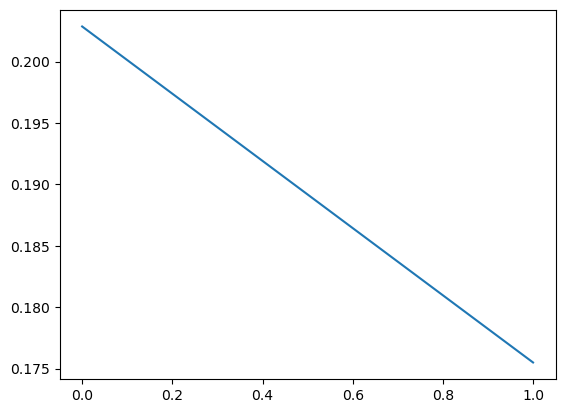

In [5]:
from data import TAPDataLoader

reload(train)
from train import Trainer

# Specific to Transformer
cfg['model_args']['daily_in_size'] = len(dataset.daily_features)
cfg['model_args']['irregular_in_size'] = len(dataset.irregular_features)
cfg['model_args']['static_in_size'] = len(dataset.static_features)
cfg['model_args']['seq_length'] = cfg['sequence_length']

dataloader = TAPDataLoader(cfg, dataset)
trainer = Trainer(cfg, dataloader)
trainer.start_training()

In [ ]:
# Resume training. Either directly from memory or loading a checkpoint.
import optax

# trainer.load_state('epoch100')
# trainer.load_last_state()

more_epochs = 0
new_schedule = optax.exponential_decay(0.01, trainer.epoch+more_epochs, 0.001, transition_begin=trainer.epoch)
trainer.lr_schedule = new_schedule
trainer.num_epochs += more_epochs

#Have to make a new dataloader when the last one is interrupted. 
trainer.dataloader = TAPDataLoader(cfg, dataset) 
trainer.start_training() 

In [ ]:
reload(evaluate)
from evaluate import predict, get_all_metrics

# basin = np.random.choice(dataset.basins).tolist()
basin = 'USGS-09367540'

cfg['data_subset'] = 'predict'
cfg['basin_subset'] =  basin
cfg['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(cfg, dataset)

results = predict(trainer.model, dataloader, seed=0, denormalize=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0

results = results.reset_index()
results = results.sort_values(by='date')
results = results.drop(columns=['basin'])
results.set_index('date', inplace=True)

metrics = get_all_metrics(results['obs'],results['pred'])
metrics

In [ ]:
# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'].plot(ax=ax)
results['obs'].plot(ax=ax,linestyle='None',marker='.')

plt.title(f"Basin: {basin}, KGE: {metrics['kge']:0.4f}")
plt.legend()
fig.autofmt_xdate()
# plt.ylim([0,20000])
plt.show()

In [ ]:
basin

In [ ]:
"""
'USGS-09367540'
"""

In [ ]:
results.plot.scatter('obs','pred')
plt.gca().axis('square')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([0,20])
# plt.ylim([0,20])
plt.show()

In [ ]:
import train
from data import TAPDataset, TAPDataLoader

state_dir = Path("../runs/notebook/20240603_1359/epoch18")
cfg, model, trainer_state, opt_state = train.load_state(state_dir)
dataset = TAPDataset(cfg)

In [ ]:
reload(evaluate)
from evaluate import predict, get_all_metrics

cfg['data_subset'] = 'test'
cfg['num_workers'] = 4
dataloader = TAPDataLoader(cfg, dataset)

results = predict(model, dataloader, seed=0, denormalize=True)
results['pred'] = results['pred']# * (results['pred']>0) #Clip predictions to 0

# results = results.reset_index()
# results = results.sort_values(by='date')

metrics = get_all_metrics(results['obs'],results['pred'])
metrics

In [ ]:
%matplotlib widget
plt.close('all')
plt.scatter(batch['y'][...,-1],pred[...,-1])
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
xd = axes[0].imshow(batch['x_dd'][:,:,0],aspect='auto')
fig.colorbar(xd, ax=axes[0])
xs = axes[1].imshow(batch['x_s'],aspect='auto')
fig.colorbar(xs, ax=axes[1]) 

In [ ]:
batch['x_dd'][:,:,0].shape

In [ ]:
basins[idx_max_err]

In [ ]:
positional_encoding = trainer.model.d_encoder.embedder.positional_encoding

plt.figure(figsize=(10, 8))
plt.imshow(positional_encoding, cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Positional Encodings')
plt.show()